In [122]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import openweathermapy as owm
from pprint import pprint
from census import Census
import pandas as pd
import numpy as np
import gmaps
import requests
import json
import time
import csv

# Import API key
# Import pyzillow 
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults

# Import Census and Gmaps API Key
from config import (census_key, gkey)
c = Census(census_key, year=2016)

In [123]:
# Request census API
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                        "B19301_001E", "B17001_002E", "B25077_001E",
                        "B08136_003E", "B08301_003E"), 
                        {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B25077_001E": "Median Home Value ($)",
                                      "B08136_003E": "Time spent commuting (in minutes)",
                                      "B08301_003E": "Means of Transportation to Work",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate","Median Home Value ($)",
                       "Time spent commuting (in minutes)","Means of Transportation to Work"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


Zipcode  Population  Median Age  Household Income  Per Capita Income  \
0   01001     17423.0        45.0           56714.0            30430.0   
1   01002     29970.0        23.2           48923.0            26072.0   
2   01003     11296.0        19.9            2499.0             3829.0   
3   01005      5228.0        44.1           70568.0            32169.0   
4   01007     14888.0        42.5           80502.0            36359.0   

   Poverty Count  Poverty Rate  Median Home Value ($)  \
0         1462.0      8.391207               202800.0   
1         8351.0     27.864531               344000.0   
2           54.0      0.478045           -666666666.0   
3          230.0      4.399388               213700.0   
4         1410.0      9.470715               258000.0   

   Time spent commuting (in minutes)  Means of Transportation to Work  
0                                NaN                           7496.0  
1                           188755.0                           8650.0  
2                                NaN                            618.0  
3                                NaN                           1832.0  
4                                NaN                           6368.0

In [124]:
# Import the original data we download from groverment database. Use dtype="object"
zipcode_data = pd.read_csv("Resources/bayarea_zipcodes.csv", dtype="object", encoding="utf-8")
# Visualize
print(len(zipcode_data))
zipcode_data.head(10)

214


PO_NAME Zipcode STATE       Area__     Length__          Lng  \
0             NAPA   94558    CA  12313263537  995176.2253  -122.103292   
1        FAIRFIELD   94533    CA  991786103.4  200772.5566  -121.947475   
2            DIXON   95620    CA   7236949521  441860.2014  -121.653355   
3           SONOMA   95476    CA   3001414165  311318.5463  -122.406843   
4             NAPA   94559    CA   1194301745  359104.6466  -122.293685   
5         PETALUMA   94954    CA   2006544443  267474.4906  -122.457669   
6        RIO VISTA   94571    CA   4454445620  492056.7524  -121.862462   
7       TRAVIS AFB   94535    CA  302939707.7  95232.00842  -121.896539   
8  AMERICAN CANYON   94503    CA  693134128.3  136394.6951  -122.204187   
9           NOVATO   94949    CA  431605416.6  119395.6721  -122.486559   

         Lat  
0  38.513283  
1  38.301511  
2  38.313387  
3  38.155682  
4  38.155238  
5  38.116895  
6   38.06603  
7  38.286568  
8  38.209695  
9  38.100527

In [125]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(zipcode_data, census_pd, how="left", on=["Zipcode", "Zipcode"])
# Visualize
print(len(census_data_complete))
census_data_complete.head(10)


214


PO_NAME Zipcode STATE       Area__     Length__          Lng  \
0             NAPA   94558    CA  12313263537  995176.2253  -122.103292   
1        FAIRFIELD   94533    CA  991786103.4  200772.5566  -121.947475   
2            DIXON   95620    CA   7236949521  441860.2014  -121.653355   
3           SONOMA   95476    CA   3001414165  311318.5463  -122.406843   
4             NAPA   94559    CA   1194301745  359104.6466  -122.293685   
5         PETALUMA   94954    CA   2006544443  267474.4906  -122.457669   
6        RIO VISTA   94571    CA   4454445620  492056.7524  -121.862462   
7       TRAVIS AFB   94535    CA  302939707.7  95232.00842  -121.896539   
8  AMERICAN CANYON   94503    CA  693134128.3  136394.6951  -122.204187   
9           NOVATO   94949    CA  431605416.6  119395.6721  -122.486559   

         Lat  Population  Median Age  Household Income  Per Capita Income  \
0  38.513283     68366.0        41.7           77299.0            38140.0   
1  38.301511     72349.0        33.9           57316.0            24388.0   
2  38.313387     21685.0        34.4           72583.0            27274.0   
3  38.155682     37534.0        47.3           68894.0            45910.0   
4  38.155238     28355.0        37.4           65891.0            34815.0   
5  38.116895     37943.0        40.6           83713.0            36188.0   
6   38.06603      8802.0        60.5           54852.0            34173.0   
7  38.286568      4269.0        23.7           54692.0            18755.0   
8  38.209695     20366.0        35.9           83627.0            30601.0   
9  38.100527     16905.0        45.0           78568.0            55946.0   

   Poverty Count  Poverty Rate  Median Home Value ($)  \
0         5198.0      7.603195               523500.0   
1        11523.0     15.926965               249400.0   
2         2949.0     13.599262               310700.0   
3         4130.0     11.003357               547800.0   
4         2813.0      9.920649               484900.0   
5         3055.0      8.051551               475800.0   
6          882.0     10.020450               271700.0   
7          359.0      8.409464           -666666666.0   
8         1972.0      9.682805               374400.0   
9         2029.0     12.002366               644800.0   

   Time spent commuting (in minutes)  Means of Transportation to Work  
0                                NaN                          26276.0  
1                           651035.0                          22404.0  
2                                NaN                           7865.0  
3                                NaN                          12538.0  
4                                NaN                          10484.0  
5                                NaN                          13988.0  
6                            78505.0                           2165.0  
7                            13490.0                           1399.0  
8                                NaN                           7416.0  
9                           164700.0                           5789.0

In [126]:
# Remove NaN and Negative Value for the Median Home Value Coulumn 
census_data_complete = census_data_complete[(census_data_complete[["Median Home Value ($)"]]>0).all(1)]
# Visualize
census_data_complete.head(10)

PO_NAME Zipcode STATE       Area__     Length__          Lng  \
0              NAPA   94558    CA  12313263537  995176.2253  -122.103292   
1         FAIRFIELD   94533    CA  991786103.4  200772.5566  -121.947475   
2             DIXON   95620    CA   7236949521  441860.2014  -121.653355   
3            SONOMA   95476    CA   3001414165  311318.5463  -122.406843   
4              NAPA   94559    CA   1194301745  359104.6466  -122.293685   
5          PETALUMA   94954    CA   2006544443  267474.4906  -122.457669   
6         RIO VISTA   94571    CA   4454445620  492056.7524  -121.862462   
8   AMERICAN CANYON   94503    CA  693134128.3  136394.6951  -122.204187   
9            NOVATO   94949    CA  431605416.6  119395.6721  -122.486559   
10           NOVATO   94945    CA  753717019.2  159439.8805  -122.486559   

          Lat  Population  Median Age  Household Income  Per Capita Income  \
0   38.513283     68366.0        41.7           77299.0            38140.0   
1   38.301511     72349.0        33.9           57316.0            24388.0   
2   38.313387     21685.0        34.4           72583.0            27274.0   
3   38.155682     37534.0        47.3           68894.0            45910.0   
4   38.155238     28355.0        37.4           65891.0            34815.0   
5   38.116895     37943.0        40.6           83713.0            36188.0   
6    38.06603      8802.0        60.5           54852.0            34173.0   
8   38.209695     20366.0        35.9           83627.0            30601.0   
9   38.100527     16905.0        45.0           78568.0            55946.0   
10  38.100527     19095.0        44.4           90685.0            45573.0   

    Poverty Count  Poverty Rate  Median Home Value ($)  \
0          5198.0      7.603195               523500.0   
1         11523.0     15.926965               249400.0   
2          2949.0     13.599262               310700.0   
3          4130.0     11.003357               547800.0   
4          2813.0      9.920649               484900.0   
5          3055.0      8.051551               475800.0   
6           882.0     10.020450               271700.0   
8          1972.0      9.682805               374400.0   
9          2029.0     12.002366               644800.0   
10         1531.0      8.017806               682900.0   

    Time spent commuting (in minutes)  Means of Transportation to Work  
0                                 NaN                          26276.0  
1                            651035.0                          22404.0  
2                                 NaN                           7865.0  
3                                 NaN                          12538.0  
4                                 NaN                          10484.0  
5                                 NaN                          13988.0  
6                             78505.0                           2165.0  
8                                 NaN                           7416.0  
9                            164700.0                           5789.0  
10                                NaN                           6127.0

In [127]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
heat_locations = census_data_complete[["Lat", "Lng"]].astype(float)

# Convert Median Home Value to float and store
# HINT: be sure to handle NaN values
median_home_value = census_data_complete["Median Home Value ($)"].astype(float)


In [108]:
# Create a house price Heatmap layer
fig = gmaps.figure()

# Adjust heat_layer setting to help with heatmap dissipating on zoom
house_layer = gmaps.heatmap_layer(heat_locations, weights=median_home_value, dissipating=False, max_intensity=0.8, point_radius = 0.07)

fig.add_layer(house_layer)

fig

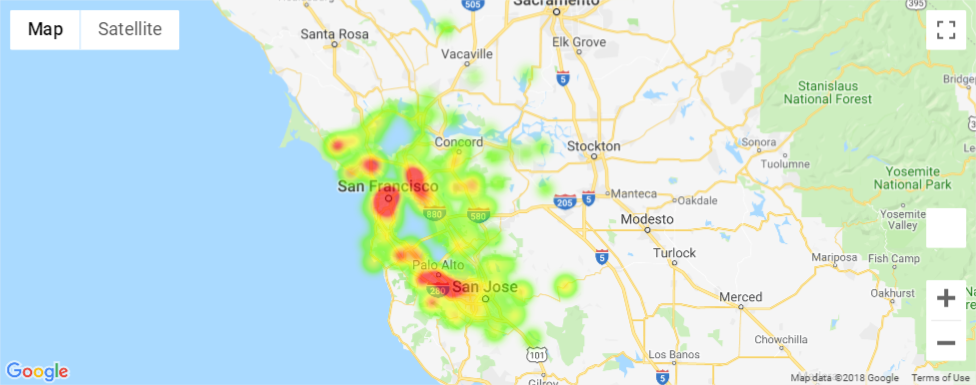

In [72]:
# Add a traffic layer upon house price Heatmap layer
fig = gmaps.figure(center=(37.58, -122.30), zoom_level = 9)
fig.add_layer(gmaps.traffic_layer())
fig.add_layer(house_layer)
#house_layer.opacity = 0.2
fig

Figure(layout=FigureLayout(height='420px'))

In [128]:
# Convert Population to float and store
# HINT: be sure to handle NaN values
population = census_data_complete["Population"].astype(float)

# Create a Population Heatmap layer
fig = gmaps.figure()

# Adjust heat_layer setting to help with heatmap dissipating on zoom
population_layer = gmaps.heatmap_layer(heat_locations, weights=population, dissipating=False, max_intensity=0.8, point_radius = 0.07)

fig.add_layer(population_layer)

fig

Figure(layout=FigureLayout(height='420px'))

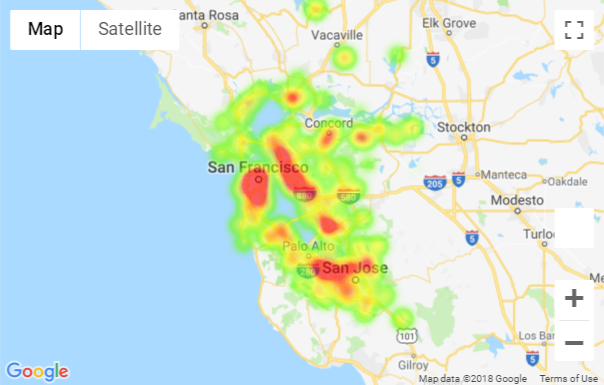

In [19]:
def to_lat_lng(json):
  return '{0}, {1}'.format(json["lat"], json['lng'])

def get_cities_df(cities):
    points = []
    north_easts = []
    south_wests = []
    
    for target_city in cities: 
        # Build the endpoint URL
        target_url = ('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}').format(target_city, gkey)
        print(target_url)
        # Run a request to endpoint and convert result to json
        response = requests.get(target_url).json()
        geometry = response["results"][0]["geometry"]

        # Extract latitude and longitude.
        points.append(to_lat_lng(geometry["location"]))
        north_easts.append(to_lat_lng(geometry["bounds"]["northeast"]))
        south_wests.append(to_lat_lng(geometry["bounds"]["southwest"]))

    return pd.DataFrame({
        "City": cities,
        "Point": points,
        "Northeast": north_easts,
        "Southwest": south_wests,
    }) 

cities = ["San Francisco, California", "Napa, California", "Sonoma, California", "San Mateo, California", "Belmont, California", "Newark, California", "Hayward, California", "Redwood City, California", "Berkeley, California", "Menlo Park, California", "Palo Alto, California", "Mountain View, California", "Los Altos, California", "Sunnyvale, California", "Cupertino, California", "Santa Clara, California", "San Jose, California", "Milpitas, California", "Fremont, California", "Livermore, California", "Dublin, California"]



In [20]:
def get_response(url, params):
    response = requests.get(url, params=params).json()
    if response['status'] == 'OK':
        return response
    else:
        print('Not OK response: ' + response['status'])
        return None

# Returns DataFrame
def request_places(city, location, type, gkey):    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    # rankby:distance will result INVALID_REQUSET
    params = {
        "location": location,
        "radius": 10000, # hard-code distance
        "type": type,
        "key": gkey,
    }

    response = get_response(base_url, params)
    if (response is None):
        print('No reslut')
        return []
    
    count = 1
    results = response['results']
    
    # If there is no page token, return result, otherwise concat result with next page.
    while ((count < 5) and (response is not None) and ('next_page_token' in response)):
        count = count + 1
        results.extend(response['results'])
        token = response['next_page_token']
        
        print(f'Sleep and get next page: {count}')
        
        # Sleep a while so that token can be used.
        time.sleep(3)
        params = {
            "location": location,
            "radius": 10000, # hard-code distance
            "type": type,
            "key": gkey,
            "page_token": response['next_page_token'],
        }
        base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        response = get_response(base_url, params)
    
    print(f'Total page count: {count}')
    return results

def to_data_frame(city, type, results):
    cities = []
    types = []
    place_ids = []
    names = []
    poi = []
    vicnities = []
    lat = []
    lng = []
    
    for result in results:
        # Skip locality place, e.g. Palo Alto.
        if ('locality' in result['types']):
            continue

        cities.append(city)
        types.append(type)
        place_ids.append(result['place_id'])
        names.append(result['name'])
        poi.append(result['types'])
        vicnities.append(result['vicinity'])
        lat.append(result['geometry']['location']['lat'])
        lng.append(result['geometry']['location']['lng'])
    
    return pd.DataFrame({
        'City': cities,
        'Type': types,
        'Place ID': place_ids,
        'Name': names,
        'Point of interests': poi,
        'Address': vicnities,
        'Lat': lat,
        'Lng': lng,
    })

def get_places_data_frame(city, location, type, gkey):
    print(f'Getting plcaes, city: "{city}", location: "{location}", type: "{type}"');
    results = request_places(city, location, type, gkey)
    return to_data_frame(city, type, results) 

In [22]:
cities_df = pd.read_csv("cities.csv")
type = 'school'

def get_all_places_data_frame(type, gkey):
    frames = [];
    for index, row in cities_df.iterrows():
        frames.append(get_places_data_frame(row['City'], row['Point'], type, gkey))
    return pd.concat(frames)

place_df = get_all_places_data_frame(type, gkey)
place_df.to_csv(type + '.csv')
place_df

Getting plcaes, city: "San Francisco, California", location: "37.7749295, -122.4194155", type: "school"
Total page count: 3
Getting plcaes, city: "Redwood City, California", location: "37.48521520000001, -122.2363548", type: "school"
Total page count: 3
Getting plcaes, city: "Berkeley, California", location: "37.8715926, -122.272747", type: "school"
Total page count: 3
Getting plcaes, city: "Palo Alto, California", location: "37.4418834, -122.1430195", type: "school"
Total page count: 3
Getting plcaes, city: "Mountain View, California", location: "37.3860517, -122.0838511", type: "school"
Total page count: 1
Getting plcaes, city: "Sunnyvale, California", location: "37.36883, -122.0363496", type: "school"
Total page count: 1
Getting plcaes, city: "Cupertino, California", location: "37.3229978, -122.0321823", type: "school"
Total page count: 1
Getting plcaes, city: "Santa Clara, California", location: "37.3541079, -121.9552356", type: "school"
Total page count: 1
Getting plcaes, city: "S

City    Type                     Place ID  \
0   San Francisco, California  school  ChIJi_z_a6KAhYARHyEzLOKy6xQ   
1   San Francisco, California  school  ChIJu2l-LmWAhYARxmTpj4vb0I8   
2   San Francisco, California  school  ChIJEXlt4TJ-j4ARRpaWbbt3zco   
3   San Francisco, California  school  ChIJU7vCd5F9j4AR9GT0sizLXwo   
4   San Francisco, California  school  ChIJBc_rV-eAhYARxkitrz4kdj4   
5   San Francisco, California  school  ChIJgaTBe499j4ARxsYjNvqyYZY   
6   San Francisco, California  school  ChIJXS6-VzOHhYARd7uawbWEhlM   
7   San Francisco, California  school  ChIJLbVZeqN9j4AR_U7DEiiHSNY   
8   San Francisco, California  school  ChIJvXl2weCAhYARmuP3Xwe2a2s   
9   San Francisco, California  school  ChIJ415kURh-j4ARPfBAwXpgEWk   
10  San Francisco, California  school  ChIJyzWlA2WAhYARbUwc9td81FY   
11  San Francisco, California  school  ChIJtVu3Vip8j4ARtCskvCHVsnI   
12  San Francisco, California  school  ChIJv52BnPuAhYARuybUbBJxOZ4   
13  San Francisco, California  school  ChIJk3MvJZaAhYAR_Ou2cdRuun8   
14  San Francisco, California  school  ChIJL-ABOn59j4AR3SyXX8c88DA   
15  San Francisco, California  school  ChIJgzCrm4iAhYARU3na9OZJ6vs   
16  San Francisco, California  school  ChIJ0dQTi4N-j4ARBPh_xMRWuqg   
17  San Francisco, California  school  ChIJxezEGJ-AhYARO1_NzQydKhA   
18  San Francisco, California  school  ChIJ_RUEIp-AhYARcsgky6nEFRw   
19  San Francisco, California  school  ChIJ3dD4EJyAhYARQvr-cXNJBPU   
20  San Francisco, California  school  ChIJi_z_a6KAhYARHyEzLOKy6xQ   
21  San Francisco, California  school  ChIJu2l-LmWAhYARxmTpj4vb0I8   
22  San Francisco, California  school  ChIJEXlt4TJ-j4ARRpaWbbt3zco   
23  San Francisco, California  school  ChIJU7vCd5F9j4AR9GT0sizLXwo   
24  San Francisco, California  school  ChIJBc_rV-eAhYARxkitrz4kdj4   
25  San Francisco, California  school  ChIJgaTBe499j4ARxsYjNvqyYZY   
26  San Francisco, California  school  ChIJXS6-VzOHhYARd7uawbWEhlM   
27  San Francisco, California  school  ChIJLbVZeqN9j4AR_U7DEiiHSNY   
28  San Francisco, California  school  ChIJvXl2weCAhYARmuP3Xwe2a2s   
29  San Francisco, California  school  ChIJ415kURh-j4ARPfBAwXpgEWk   
..                        ...     ...                          ...   
30        Fremont, California  school  ChIJnwZWKS3Bj4AR6iYNF_U-tn8   
31        Fremont, California  school  ChIJ3etPza7Aj4AR6Mqf9XJKlXs   
32        Fremont, California  school  ChIJIw4-bIK_j4ARRWf9wTrD1Ko   
33        Fremont, California  school  ChIJ36T9Tzi-j4ARAmD8QlZwFDA   
34        Fremont, California  school  ChIJiaERoP--j4AR12EXunVmD8o   
35        Fremont, California  school  ChIJtRp-plu-j4ARw4PzordiGyU   
36        Fremont, California  school  ChIJ08qxnCbBj4AR1_3R-cCR1iI   
37        Fremont, California  school  ChIJHyyKKfvAj4ARTmBfYVWYp04   
38        Fremont, California  school  ChIJM5MlmgO-j4ARID2piyHTHsE   
39        Fremont, California  school  ChIJGcVQndG_j4ARUvA5cG8mf7M   
40        Fremont, California  school  ChIJE1WOHjTHj4AR_1XQHn8CEMc   
41        Fremont, California  school  ChIJ3xyX2n2_j4ARsPcmftHPp2g   
42        Fremont, California  school  ChIJzR9FszHBj4ARbo09jf09Fp8   
43        Fremont, California  school  ChIJG92P45u_j4AR6btTDfJf4Hw   
44        Fremont, California  school  ChIJG8B0vb2_j4AR2PwPZrDNqC8   
45        Fremont, California  school  ChIJlfpEP1K_j4AR565l4tSZckM   
46        Fremont, California  school  ChIJ4eBWT4C_j4ARlSLzszit2D8   
47        Fremont, California  school  ChIJ4aAqgZmVj4AR5THPeuWHn9Q   
48        Fremont, California  school  ChIJIenHEwWVj4ARAxXOa3dJ124   
49        Fremont, California  school  ChIJY_JiYJqVj4ARA2UAUwHd47E   
50        Fremont, California  school  ChIJnwZWKS3Bj4AR6iYNF_U-tn8   
51        Fremont, California  school  ChIJ3etPza7Aj4AR6Mqf9XJKlXs   
52        Fremont, California  school  ChIJIw4-bIK_j4ARRWf9wTrD1Ko   
53        Fremont, California  school  ChIJ36T9Tzi-j4ARAmD8QlZwFDA   
54        Fremont, California  school  ChIJiaERoP--j4AR12EXunVmD8o   
55        Fremont, California  scho

In [76]:
# Read school csv file
school_data = pd.read_csv("Resources/school.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
school_locations = school_data[["Lat", "Lng"]].astype(float)
# Create school symbol layer
school_layer = gmaps.symbol_layer(
    school_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
)

# Create a school and house price combined map
fig = gmaps.figure()

fig.add_layer(house_layer)
fig.add_layer(school_layer)

fig

In [106]:
Create a school and population combined map
fig = gmaps.figure()

fig.add_layer(population_layer)
fig.add_layer(school_layer)

fig


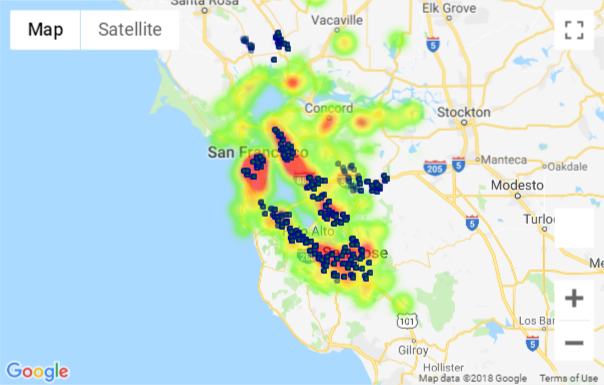

In [105]:
# Read supermarket csv file
supermarket_data = pd.read_csv("Resources/supermarket.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
supermarket_locations = supermarket_data[["Lat", "Lng"]].astype(float)
# Create supermarket symbol layer
supermarket_layer = gmaps.symbol_layer(
    supermarket_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
)

# Create a supermarket and house price combined map
fig = gmaps.figure()

fig.add_layer(house_layer)
fig.add_layer(supermarket_layer)

fig

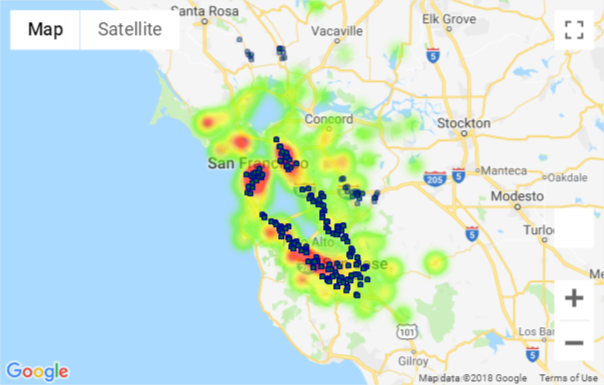

In [107]:
# Read department csv file
department_store_data = pd.read_csv("Resources/department_store.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
department_store_locations = department_store_data[["Lat", "Lng"]].astype(float)
# Create department symbol layer
department_store_layer = gmaps.symbol_layer(
    department_store_locations, fill_color='red',
    stroke_color='purple', scale=2,
)

# Create a supermarket and department_store vs population map
fig = gmaps.figure()

fig.add_layer(population_layer)
fig.add_layer(supermarket_layer)
fig.add_layer(department_store_layer)

fig

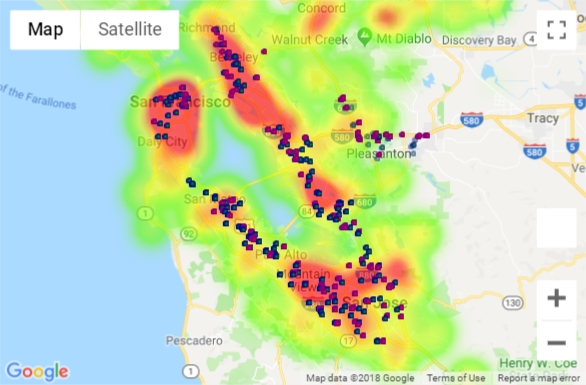

In [110]:
# Read restaurant csv file
restaurant_data = pd.read_csv("Resources/restaurant.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
restaurant_locations = restaurant_data[["Lat", "Lng"]].astype(float)
# Create restaurant symbol layer
restaurant_layer = gmaps.symbol_layer(
    restaurant_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
)

# Create a restaurant and house price combined map
fig = gmaps.figure()

fig.add_layer(house_layer)
fig.add_layer(restaurant_layer)

fig

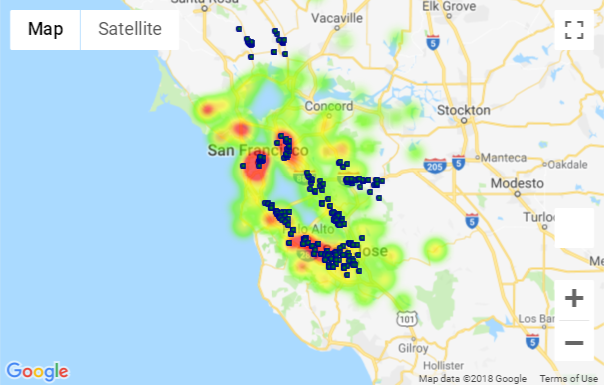

In [111]:
# Create a supermarket and population combined map
fig = gmaps.figure()

fig.add_layer(population_layer)
fig.add_layer(restaurant_layer)

fig

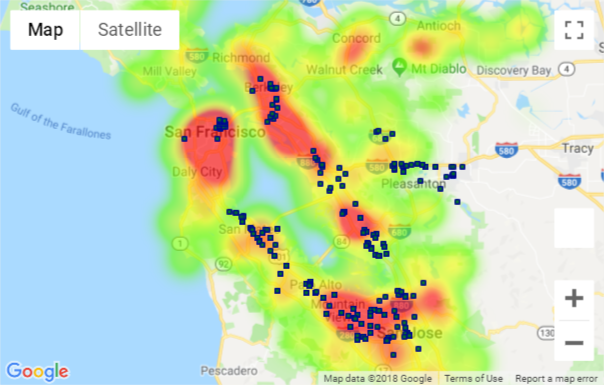

In [113]:
# Read local_government_office csv file
government_data = pd.read_csv("Resources/local_government_office.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
government_locations = government_data[["Lat", "Lng"]].astype(float)
# Create local_government_office symbol layer
government_layer = gmaps.symbol_layer(
    government_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
)

# Read city_hall csv file
city_hall_data = pd.read_csv("Resources/city_hall.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
city_hall_locations = city_hall_data[["Lat", "Lng"]].astype(float)
# Create city_hall symbol layer
city_hall_layer = gmaps.symbol_layer(
    city_hall_locations, fill_color='red',
    stroke_color='purple', scale=2,
)

# Create a local_government_office and city_hall vs population combined map
fig = gmaps.figure()

fig.add_layer(population_layer)
fig.add_layer(government_layer)
fig.add_layer(city_hall_layer)
fig

Figure(layout=FigureLayout(height='420px'))

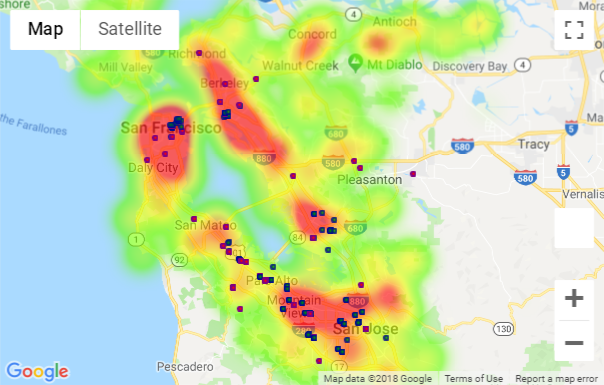

In [129]:
# Read doctor csv file
doctor_data = pd.read_csv("Resources/doctor.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
doctor_locations = doctor_data[["Lat", "Lng"]].astype(float)
# Create doctor symbol layer
doctor_layer = gmaps.symbol_layer(
    doctor_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
)

# Read church csv file
church_data = pd.read_csv("Resources/church.csv", dtype="object", encoding="utf-8")
# Configure gmaps with API key
gmaps.configure(api_key=gkey)
# Store 'Lat' and 'Lng' into  locations 
church_locations = church_data[["Lat", "Lng"]].astype(float)
# Create church symbol layer
church_layer = gmaps.symbol_layer(
    church_locations, fill_color='red',
    stroke_color='purple', scale=2,
)

# Create a doctor & church vs population combined map
fig = gmaps.figure()

fig.add_layer(population_layer)
fig.add_layer(doctor_layer)
fig.add_layer(church_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [78]:
# address = '4691 hampshire way, fremont,ca'
# zipcode = '94538'
# zillow_data = ZillowWrapper("X1-ZWz1gocnjquzgr_23up5")
# deep_search_response = zillow_data.get_deep_search_results(address,zipcode)
# result = GetDeepSearchResults(deep_search_response)
# result.last_sold_price
# #response = requests.get(deep_search_response).json()
